In [ ]:
import numpy as np
from scipy.integrate import solve_ivp

# Parámetros
M = 5.0       # masa del disco
m = 0.1       # masa de cada cuchilla
R = 1.0       # radio del disco
r = 0.8       # distancia pivote
L = 0.8       # longitud de la cuchilla

# Inercias
I_disc  = 0.5 * M * R**2
I_blade = (1/3) * m * L**2

# Momento de inercia total
I_tot = I_disc + 2*(m*r**2 + I_blade)


In [ ]:
def tau_motor(t):
    return 2.0

In [ ]:
def tau_disc_b(phi_dot, theta, theta_dot, b):
    term_phi = b * phi_dot * np.sin(theta) * (r*L**2/2 + (L**3/3)*np.cos(theta))
    term_th  = b * theta_dot * np.sin(theta) * (L**3/3)
    return term_phi + term_th


In [ ]:
def theta_dd(phi_dot, theta, theta_dot, b, c_th, k, theta0):
    # términos centrífugos
    cent1 = 0.5*m*r*L*phi_dot**2*np.sin(theta)
    cent2 = (1/3)*m*L**2*phi_dot**2*np.sin(theta)*np.cos(theta)
    # torque de pasto sobre cuchilla
    tau_g = b*phi_dot*np.sin(theta)*(r*L**2/2) + b*theta_dot*np.sin(theta)*(L**3/3)
    # resorte y amortiguamiento
    tau_s = -k*(theta-theta0)
    tau_d = -c_th*theta_dot

    return (-cent1 - cent2 - tau_g + tau_s + tau_d) / I_blade


In [ ]:
def odes(t, y):
    phi, phidot, th1, dth1, th2, dth2 = y

    # motor y fricción del disco
    phidd = (tau_motor(t)
             - tau_disc_b(phidot, th1, dth1, b1)
             - tau_disc_b(phidot, th2, dth2, b2)
             - c_disk*phidot) / I_tot

    dth1dd = theta_dd(phidot, th1, dth1, b1, c_th1, k1, theta01)
    dth2dd = theta_dd(phidot, th2, dth2, b2, c_th2, k2, theta02)

    return [phidot, phidd, dth1, dth1dd, dth2, dth2dd]


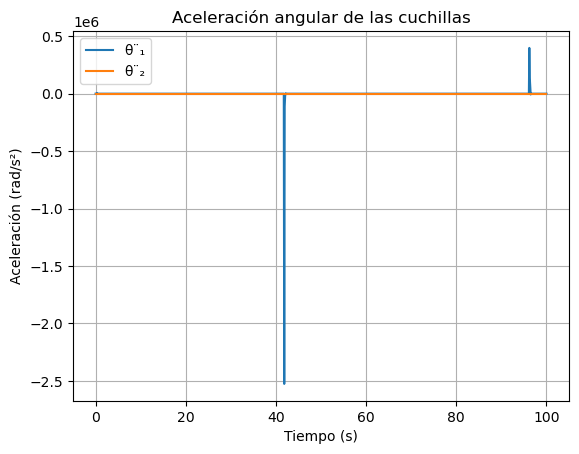

In [7]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
# Parámetros
M = 5.0       # masa del disco
m = 0.1       # masa de cada cuchilla
R = 1.0       # radio del disco
r = 0.8       # distancia pivote
L = 0.8       # longitud de la cuchilla

# ------------------------
# Coeficientes ajustables
# ------------------------
b1 = 1e4     # densidad de pasto cuchilla 1
b2 = 1       # densidad de pasto cuchilla 2
c_disk = 1     # fricción viscosa del disco
c_th1 = 1    # amortiguamiento pivote cuchilla 1
c_th2 = 0.1    # amortiguamiento pivote cuchilla 2
k1 = 5.0         # constante de resorte torsional cuchilla 1
k2 = 0         # constante de resorte torsional cuchilla 2
theta01 = 3.14   # ángulo “full extend” cuchilla 1
theta02 = 0    # ángulo “full extend” cuchilla 2

def tau_motor(t):
    return 2.0
# Inercias
I_disc  = 0.5 * M * R**2
I_blade = (1/3) * m * L**2

# Momento de inercia total (haciendo explícito m r^2)
I_tot = I_disc + 2*(m*r**2 + I_blade)

def tau_disc_b(phi_dot, theta, theta_dot, b):
    term_phi = b * phi_dot * np.sin(theta) * (r*L**2/2 + (L**3/3)*np.cos(theta))
    term_th  = b * theta_dot * np.sin(theta) * (L**3/3)
    return term_phi + term_th

def theta_dd(phi_dot, theta, theta_dot, b, c_th, k, theta0):
    # términos centrífugos
    cent1 = 0.5*m*r*L*phi_dot**2*np.sin(theta)
    cent2 = (1/3)*m*L**2*phi_dot**2*np.sin(theta)*np.cos(theta)
    # torque de pasto sobre cuchilla
    tau_g = b*phi_dot*np.sin(theta)*(r*L**2/2) + b*theta_dot*np.sin(theta)*(L**3/3)
    # resorte y amortiguamiento
    tau_s = -k*(theta-theta0)
    tau_d = -c_th*theta_dot

    return (-cent1 - cent2 - tau_g + tau_s + tau_d) / I_blade

def odes(t, y):
    phi, phidot, th1, dth1, th2, dth2 = y

    # motor y fricción del disco
    phidd = (tau_motor(t)
             - tau_disc_b(phidot, th1, dth1, b1)
             - tau_disc_b(phidot, th2, dth2, b2)
             - c_disk*phidot) / I_tot

    dth1dd = theta_dd(phidot, th1, dth1, b1, c_th1, k1, theta01)
    dth2dd = theta_dd(phidot, th2, dth2, b2, c_th2, k2, theta02)

    return [phidot, phidd, dth1, dth1dd, dth2, dth2dd]

y0     = [0, 0, theta01, 0, theta02, 0]
t_span = (0, 100)
t_eval = np.linspace(*t_span, 1000)

sol = solve_ivp(odes, t_span, y0, t_eval=t_eval)


t      = sol.t
phi    = sol.y[0]
phidot = sol.y[1]
th1    = sol.y[2]
dth1   = sol.y[3]
th2    = sol.y[4]
dth2   = sol.y[5]

# aceleraciones θ¨(t)
ddth1 = np.array([theta_dd(phidot[i], th1[i], dth1[i], b1, c_th1, k1, theta01)
                  for i in range(len(t))])
ddth2 = np.array([theta_dd(phidot[i], th2[i], dth2[i], b2, c_th2, k2, theta02)
                  for i in range(len(t))])

plt.figure()
plt.plot(t, ddth1, label='θ¨₁')
plt.plot(t, ddth2, label='θ¨₂')
plt.xlabel('Tiempo (s)')
plt.ylabel('Aceleración (rad/s²)')
plt.title('Aceleración angular de las cuchillas')
plt.legend()
plt.grid(True)